<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

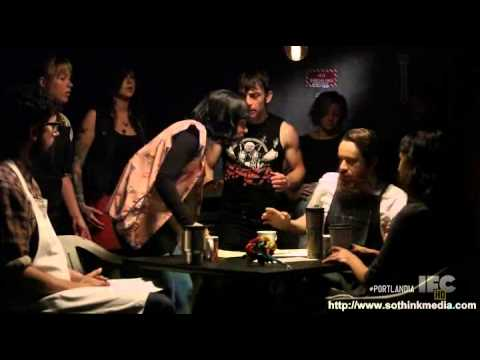

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'c:\\Users\\Nick\\Documents\\GitHub\\DS-Unit-4-Sprint-1-NLP'

In [1]:
'''
Imports and dataframe creation
'''
from collections import Counter
from nltk.stem import PorterStemmer
from spacy.tokenizer import Tokenizer
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import spacy
import squarify

nlp = spacy.load("en_core_web_lg")

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

df = pd.read_csv(url)
df.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [2]:
print(df.shape)
df.dtypes

(7616, 3)


coffee_shop_name    object
full_review_text    object
star_rating         object
dtype: object

In [3]:
# Drop 'star rating' and convert to int
df['star_rating'] = df['star_rating'].str.replace('.0 star rating', '').astype('int')

In [4]:
df.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4


In [8]:
# Use spacy tokenizer for reviews
tokenizer = Tokenizer(nlp.vocab)

# Tokenizer Pipe

tokens = []

""" Make them tokens """
for doc in tokenizer.pipe(df['full_review_text']):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

df['tokens'] = tokens

In [11]:
# To compare with tokens to ensure we got everything
df['full_review_text'][0]

' 11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? '

In [10]:
# Looks good!
df['tokens'][0]

[' ',
 '11/25/2016',
 '1',
 'check-in',
 'Love',
 'love',
 'loved',
 'the',
 'atmosphere!',
 'Every',
 'corner',
 'of',
 'the',
 'coffee',
 'shop',
 'had',
 'its',
 'own',
 'style,',
 'and',
 'there',
 'were',
 'swings!!!',
 'I',
 'ordered',
 'the',
 'matcha',
 'latte,',
 'and',
 'it',
 'was',
 'muy',
 'fantastico!',
 'Ordering',
 'and',
 'getting',
 'my',
 'drink',
 'were',
 'pretty',
 'streamlined.',
 'I',
 'ordered',
 'on',
 'an',
 'iPad,',
 'which',
 'included',
 'all',
 'beverage',
 'selections',
 'that',
 'ranged',
 'from',
 'coffee',
 'to',
 'wine,',
 'desired',
 'level',
 'of',
 'sweetness,',
 'and',
 'a',
 'checkout',
 'system.',
 'I',
 'got',
 'my',
 'latte',
 'within',
 'minutes!',
 ' ',
 'I',
 'was',
 'hoping',
 'for',
 'a',
 'typical',
 'heart',
 'or',
 'feather',
 'on',
 'my',
 'latte,',
 'but',
 'found',
 'myself',
 'listing',
 'out',
 'all',
 'the',
 'possibilities',
 'of',
 'what',
 'the',
 'art',
 'may',
 'be.',
 'Any',
 'ideas?']

In [14]:
def count(docs):
    '''
    Function to count tokens and return a dataframe
    sorted by the number of times that word was
    used in reviews
    '''
    
    word_counts = Counter()
    appears_in = Counter()
    
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())
    
    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
    
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
    
    return wc.sort_values(by='rank')

In [17]:
# Create a df using count function to use for plotting with squarify
word_count = count(df['tokens'])
word_count.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
33,the,6520,27779,1.0,0.034334,0.034334,0.856092
23,and,6804,25748,2.0,0.031824,0.066157,0.893382
64,,7616,22606,3.0,0.027940,0.094097,1.000000
41,a,6181,22085,4.0,0.027296,0.121394,0.811581
59,I,5469,19780,5.0,0.024447,0.145841,0.718093


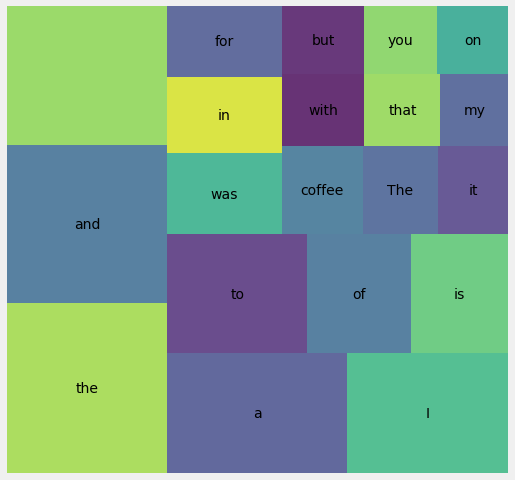

In [28]:
# Squarify word plot of top 20 most used words
top_20 = word_count[word_count['rank'] < 21]
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(8,8))
    squarify.plot(sizes=top_20['pct_total'], label=top_20['word'], alpha=.8)
    plt.axis('off')

## We've got quite a few words on here that aren't very useful!  
## Let's add some stop words to get a better look at our reviews.

In [29]:
# Recreate df['tokens'] with stop words removed
tokens = []
for i in tokenizer.pipe(df['full_review_text']):
    doc_tokens = []
    for token in i:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)
df['tokens'] = tokens 

In [30]:
df['tokens'].head()

0    [ , 11/25/2016, 1, check-in, love, love, loved...
1    [ , 12/2/2016, listed, date, night:, austin,, ...
2    [ , 11/30/2016, 1, check-in, listed, brunch, s...
3    [ , 11/25/2016, cool, decor!, good, drinks, ni...
4    [ , 12/3/2016, 1, check-in, located, northcros...
Name: tokens, dtype: object

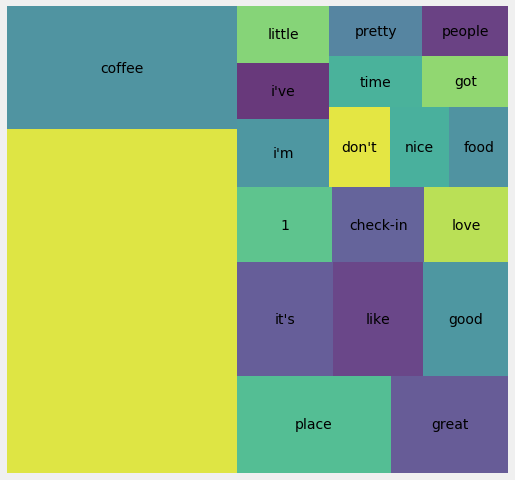

In [31]:
# Squarify word plot of top 20 most used words without stop words
word_count = count(df['tokens'])
top_20 = word_count[word_count['rank'] < 21]
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(8,8))
    squarify.plot(sizes=top_20['pct_total'], label=top_20['word'], alpha=.8)
    plt.axis('off')

In [38]:
word_count['word']

27                      
23                coffee
137                place
77                 great
274                 it's
191                 like
188                 good
7                      1
2               check-in
16                  love
297                  i'm
352                 i've
800               little
290                don't
171                 nice
423                 food
618                 time
24                pretty
20                   got
968               people
507                 come
53                austin
432                 best
47            definitely
209             friendly
25                 latte
28                  shop
779              coffee.
1014                iced
74                   try
              ...       
40364         uneventful
40369        pre-bought.
40366              nora,
40365         offsetting
40367              dish;
40371          hardened,
40370              "made
40368            house",
40373              it!).


## Still some issues, looks like '' is one of our top words.  
## We will also need to remove numbers!  
## Let's add to our stop words and try again

In [69]:
stop_words = nlp.Defaults.stop_words.union(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', '-', '/'])

In [70]:
tokens = []
for doc in tokenizer.pipe(df['full_review_text']):
    doc_tokens = []
    for token in doc:
        if token.text.lower() not in stop_words:
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)
df['tokens'] = tokens

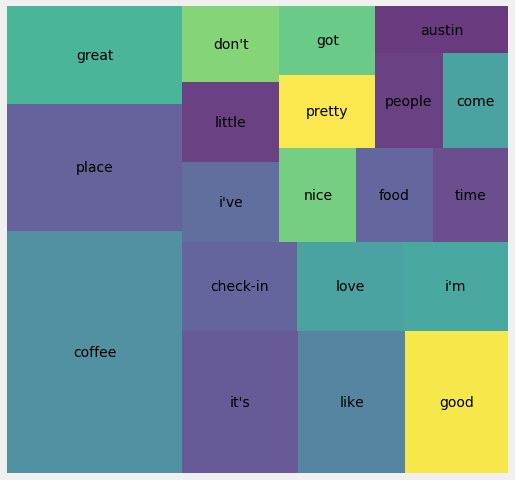

In [72]:
# Squarify word plot of top 20 most used words without updated stop words
word_count = count(df['tokens'])
top_20 = word_count[word_count['rank'] < 21]
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(8,8))
    squarify.plot(sizes=top_20['pct_total'], label=top_20['word'], alpha=.8)
    plt.axis('off')

In [73]:
word_count

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
23,coffee,4210,8058,1.0,0.020300,0.020300,0.552784
136,place,3029,4264,2.0,0.010742,0.031041,0.397715
76,great,2438,3250,3.0,0.008187,0.039229,0.320116
273,it's,2061,3117,4.0,0.007852,0.047081,0.270614
189,like,2034,2902,5.0,0.007311,0.054392,0.267069
186,good,2084,2779,6.0,0.007001,0.061393,0.273634
2,check-in,1957,1961,7.0,0.004940,0.066333,0.256959
15,love,1434,1806,8.0,0.004550,0.070882,0.188288
296,i'm,1382,1797,9.0,0.004527,0.075409,0.181460
350,i've,1164,1479,10.0,0.003726,0.079135,0.152836


## Let's use lemmatization to narrow this down even more

In [133]:
def get_lemmas(text):
    '''
    Takes input and returns a list of lemmas
    and removes all stop words defined above
    '''
    lemmas = []
    doc = nlp(text)
    for token in doc:
        if (token.text.lower() not in stop_words) & (token.pos_!= 'PRON') & (token.is_punct == False):
            lemmas.append(token.lemma_)
    return lemmas

In [132]:
df['lemmas'] = df['full_review_text'].apply(get_lemmas)
df['lemmas'].head()

0    [11/25/2016, check, love, love, love, atmosphe...
1    [12/2/2016, list, Date, Night, Austin, Ambianc...
2    [11/30/2016, check, list, Brunch, Spots, love,...
3    [11/25/2016, cool, decor, good, drink, nice, s...
4    [12/3/2016, check, locate, Northcross, mall, s...
Name: lemmas, dtype: object

In [135]:
# Remove the date from the lemmas!
for i in df['lemmas']:
    del i[0]

In [137]:
df['lemmas'].head()

0    [check, love, love, love, atmosphere, corner, ...
1    [list, Date, Night, Austin, Ambiance, Austin, ...
2    [check, list, Brunch, Spots, love, eclectic, h...
3    [cool, decor, good, drink, nice, seating, over...
4    [check, locate, Northcross, mall, shopping, ce...
Name: lemmas, dtype: object

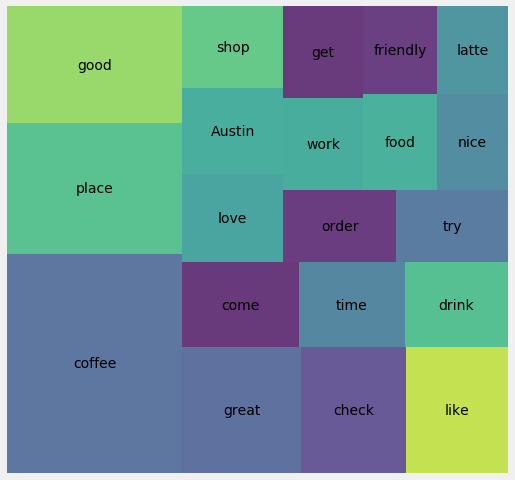

In [138]:
# Squarify word plot of top 20 most used words without updated stop words after lemmatization
word_count = count(df['lemmas'])
top_20 = word_count[word_count['rank'] < 21]
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(8,8))
    squarify.plot(sizes=top_20['pct_total'], label=top_20['word'], alpha=.8)
    plt.axis('off')

In [77]:
word_count

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
14,coffee,4826,10100,1.0,0.027690,0.027690,0.633666
122,place,3876,6021,2.0,0.016507,0.044197,0.508929
162,good,3588,5391,3.0,0.014780,0.058977,0.471113
70,great,2843,3924,4.0,0.010758,0.069735,0.373293
29,check,3175,3468,5.0,0.009508,0.079242,0.416886
165,like,2273,3379,6.0,0.009264,0.088506,0.298451
406,come,1932,2637,7.0,0.007230,0.095736,0.253676
488,time,1762,2382,8.0,0.006530,0.102266,0.231355
38,drink,1636,2339,9.0,0.006413,0.108679,0.214811
11,love,1794,2332,10.0,0.006393,0.115072,0.235557


## Let's seperate it by good and bad reviews

In [145]:
good = df[df['star_rating'] >= 4]
bad = df[df['star_rating'] < 4]
good.shape, bad.shape

((6140, 5), (1476, 5))

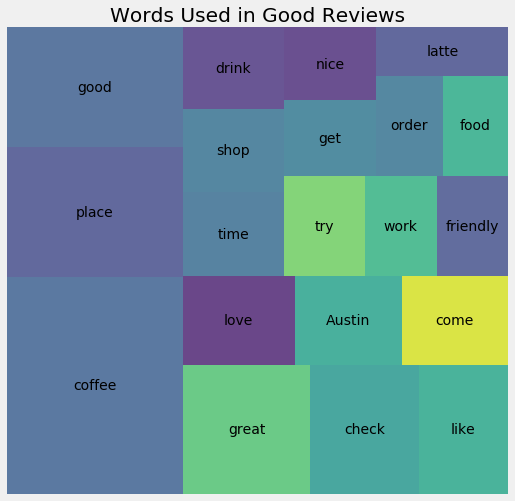

In [146]:
good_count = count(good['lemmas'])
top_20 = good_count[good_count['rank'] < 21]
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(8,8))
    squarify.plot(sizes=top_20['pct_total'], label=top_20['word'], alpha=.8)
    ax.set_title('Words Used in Good Reviews')
    plt.axis('off')

In [147]:
good_count

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
14,coffee,3904,8001,1.0,0.028674,0.028674,0.635831
120,place,3123,4795,2.0,0.017184,0.045858,0.508632
198,good,2944,4395,3.0,0.015751,0.061609,0.479479
68,great,2497,3459,4.0,0.012396,0.074005,0.406678
29,check,2686,2941,5.0,0.010540,0.084545,0.437459
201,like,1677,2434,6.0,0.008723,0.093268,0.273127
11,love,1586,2083,7.0,0.007465,0.100733,0.258306
59,Austin,1543,1986,8.0,0.007117,0.107850,0.251303
378,come,1480,1986,9.0,0.007117,0.114967,0.241042
368,time,1343,1774,10.0,0.006358,0.121325,0.218730


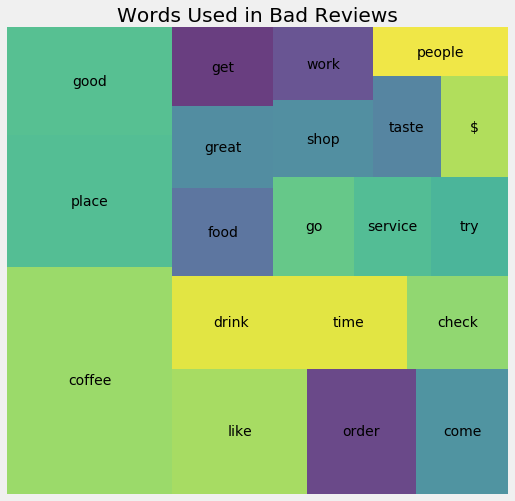

In [148]:
bad_count = count(bad['lemmas'])
top_20 = bad_count[bad_count['rank'] < 21]
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(8,8))
    squarify.plot(sizes=top_20['pct_total'], label=top_20['word'], alpha=.8)
    ax.set_title('Words Used in Bad Reviews')
    plt.axis('off')

In [149]:
bad_count

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
16,coffee,922,2099,1.0,0.026875,0.026875,0.624661
3,place,753,1226,2.0,0.015697,0.042573,0.510163
26,good,644,996,3.0,0.012753,0.055325,0.436314
29,like,596,945,4.0,0.012100,0.067425,0.403794
68,order,431,763,5.0,0.009769,0.077194,0.292005
59,come,452,651,6.0,0.008335,0.085529,0.306233
36,drink,363,610,7.0,0.007810,0.093339,0.245935
461,time,419,608,8.0,0.007785,0.101124,0.283875
95,check,489,527,9.0,0.006748,0.107872,0.331301
74,food,320,498,10.0,0.006376,0.114248,0.216802


In [156]:
good_count['word'][:10], bad_count['word'][:10]

(14     coffee
 120     place
 198      good
 68      great
 29      check
 201      like
 11       love
 59     Austin
 378      come
 368      time
 Name: word, dtype: object, 16     coffee
 3       place
 26       good
 29       like
 68      order
 59       come
 36      drink
 461      time
 95      check
 74       food
 Name: word, dtype: object)

In [157]:
# Looks like we have a LOT of repeat words. We'll have to exclude many more to really understand what makes a good/bad review
full_stop = stop_words.union(['coffee', 'place', 'good', 'like', 'check', 'come', 'time', 'try', 'work', 'shop'])
def new_lemmas(text):
    '''
    Takes input and returns a list of lemmas
    and removes all stop words defined above
    '''
    lemmas = []
    doc = nlp(text)
    for token in doc:
        if (token.text.lower() not in full_stop) & (token.pos_!= 'PRON') & (token.is_punct == False):
            lemmas.append(token.lemma_)
    return lemmas

In [159]:
x = df.copy()
x['lemmas'] = x['full_review_text'].apply(new_lemmas)
x['lemmas'].head()

0    [11/25/2016, love, love, love, atmosphere, cor...
1    [12/2/2016, list, Date, Night, Austin, Ambianc...
2    [11/30/2016, list, Brunch, Spots, love, eclect...
3    [11/25/2016, cool, decor, drink, nice, seating...
4    [12/3/2016, locate, Northcross, mall, shopping...
Name: lemmas, dtype: object

In [168]:
for i in x['lemmas']:
    del i[0]

In [169]:
x['lemmas'].head()

0    [love, love, love, atmosphere, corner, style, ...
1    [list, Date, Night, Austin, Ambiance, Austin, ...
2    [list, Brunch, Spots, love, eclectic, homey, p...
3    [cool, decor, drink, nice, seating, overpriced...
4    [locate, Northcross, mall, shopping, center, f...
Name: lemmas, dtype: object

In [170]:
new_good = x[x['star_rating'] >= 4]
new_bad = x[x['star_rating'] < 4]
new_good.shape, new_bad.shape

((6140, 5), (1476, 5))

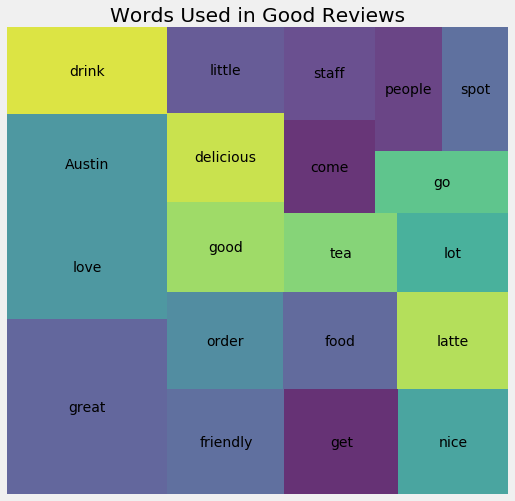

In [171]:
good_count = count(new_good['lemmas'])
top_20 = good_count[good_count['rank'] < 21]
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(8,8))
    squarify.plot(sizes=top_20['pct_total'], label=top_20['word'], alpha=.8)
    ax.set_title('Words Used in Good Reviews')
    plt.axis('off')

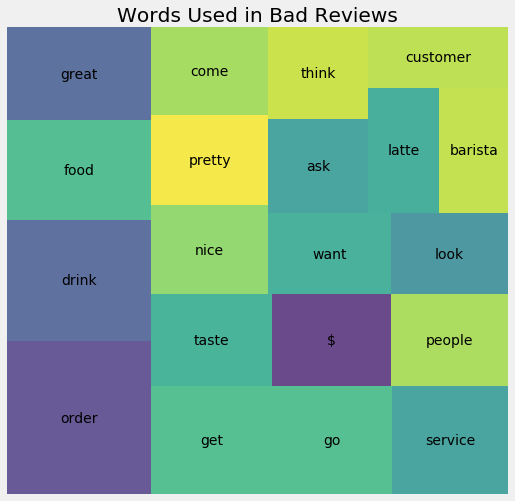

In [172]:
bad_count = count(new_bad['lemmas'])
top_20 = bad_count[bad_count['rank'] < 21]
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(8,8))
    squarify.plot(sizes=top_20['pct_total'], label=top_20['word'], alpha=.8)
    ax.set_title('Words Used in Bad Reviews')
    plt.axis('off')

In [173]:
good_count

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
64,great,2497,3459,1.0,0.013709,0.013709,0.406678
11,love,1586,2083,2.0,0.008256,0.021965,0.258306
56,Austin,1542,1985,3.0,0.007867,0.029832,0.251140
34,drink,1273,1729,4.0,0.006853,0.036685,0.207329
144,friendly,1439,1513,5.0,0.005997,0.042682,0.234365
32,get,1146,1469,6.0,0.005822,0.048504,0.186645
46,nice,1207,1426,7.0,0.005652,0.054156,0.196580
28,order,1025,1386,8.0,0.005493,0.059649,0.166938
302,food,1071,1382,9.0,0.005477,0.065126,0.174430
16,latte,926,1336,10.0,0.005295,0.070421,0.150814


In [174]:
bad_count

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
63,order,431,763,1.0,0.010749,0.010749,0.292005
32,drink,363,610,2.0,0.008594,0.019343,0.245935
69,food,320,498,3.0,0.007016,0.026358,0.216802
44,great,346,465,4.0,0.006551,0.032909,0.234417
30,get,336,449,5.0,0.006325,0.039235,0.227642
137,go,337,449,6.0,0.006325,0.045560,0.228320
27,service,335,433,7.0,0.006100,0.051660,0.226965
114,taste,280,384,8.0,0.005410,0.057070,0.189702
22,$,218,381,9.0,0.005367,0.062437,0.147696
111,people,281,374,10.0,0.005269,0.067706,0.190379


As you can see, the reality is that good and bad reviews often share many of the same words.  
We would have to take this a step further in order to get a "sentiment" rating from the reviews that would give a
clearer picture of what makes a good or bad review.

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

